In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import csv

from scipy.interpolate import make_interp_spline, make_lsq_spline
import rpy2.robjects as robjects
import pyreadr
import sys
import csv

sys.path.append("../../src/Utility")

from utility import plot_multiple_roc
from os.path import exists

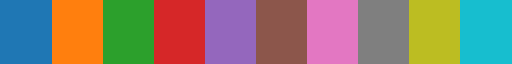

In [3]:
color_map = plt.get_cmap('tab10')
color_map

In [4]:
def remove_duplicate(x,y):
    unique_v, idx, count = np.unique(x, return_inverse=True, return_counts=True)
    m = np.zeros((unique_v.size, 2))
    m[:,0] = unique_v
    duplicate_v = np.where(count>1)[0]
    for i in duplicate_v:
        j = np.where(idx==i)[0]
        mean_val = np.mean(y[j])
        m[ i, 1] = mean_val
    single_v = np.where(count==1)[0]
    for i in single_v:
        j = np.where(idx==i)[0]
        m[i,1] = y[j]
    return m


def remove_outlier(data_list, a=2):
    mean = np.mean(data_list)
    std = np.std(data_list)
    keep = np.intersect1d(np.where(data_list <= mean + a*std)[0], np.where(data_list >= mean - a*std)[0])
    keep = np.array(keep)

    out = [data_list[x] for x in keep]
    return out, keep

In [5]:
def calculate_auc(m):
    #m is ndarray and m[:,0] denotes the fpr and m[:,1] are tpr
    m = np.vstack(([0.,0.],m))
    #print(m)
    X_Y_Spline = make_interp_spline(m[:,0], m[:,1], k=1)
    X_ = 1
    Y_ = min(X_Y_Spline(X_),1)

    x_sort = np.sort(m[:,0])
    sort_id = np.argsort(m[:, 0])
    y_sort = m[sort_id, 1]
    x_sort = np.concatenate(( x_sort, [1]))
    y_sort = np.concatenate((y_sort, [Y_]))
    n = x_sort.size
    area = 0
    for i in range(n-1):
        x_interval = x_sort[i+1]-x_sort[i]
        y_average = (y_sort[i] + y_sort[i+1])/2
        area += x_interval*y_average
    return area


def calculate_auc15(m):
    #m is ndarray and m[:,0] denotes the fpr and m[:,1] are tpr
    m = np.vstack(([0.,0.],m))
    X_Y_Spline = make_interp_spline(m[:,0], m[:,1], k=1)
    X_ = 0.15
    Y_ = min(X_Y_Spline(X_),1)

    #print('x original', m[:,0])
    #print('y original', m[:,1])
    id = np.where(m[:,0]<=0.15)[0]
    x = m[id,0]
    y = m[id,1]
    x_sort = np.sort(x)
    
    sort_id = np.argsort(x)
    y_sort = y[sort_id]
    x_sort = np.concatenate((x_sort, [0.15]))
    
    y_sort = np.concatenate((y_sort, [Y_]))
    #print('x', x_sort)
    #print('y', y_sort)
    n = x_sort.size
    area = 0
    for i in range(n-1):
        x_interval = x_sort[i+1]-x_sort[i]
        y_average = (y_sort[i] + y_sort[i+1])/2
        area += x_interval*y_average
    return area/0.15



In [6]:
def mean_auc(original_list, keep_index, bin_size=50):
    interval = 1./ bin_size
    count = np.zeros(bin_size)
    tpr_avg = np.zeros(bin_size)
    for i in keep_index:    
        m = original_list[i]
        for j, x in enumerate(m[:,0]):
            x_id = int(x//interval)
            tpr_avg[x_id] += m[j,1]
            count[x_id] += 1
    nonzero_id = np.where(count > 0)
    tpr_out = tpr_avg[nonzero_id]/count[nonzero_id]
    fpr_out = np.arange(0,1,interval)[nonzero_id]
    return np.vstack((fpr_out, tpr_out)).T


        


In [7]:
def plot_mean_auc(ax, model_path, rest_of_name, label, linestyle, color):

    auc_r = []
    m_list = []
    for i in range(10):
        p_file = model_path+"ss_{}/".format(i+1)+rest_of_name
        if(exists(p_file)):

            arr = np.load(p_file)
            sort_fpr = np.argsort(arr[:,1])

            flng = np.zeros(arr.shape)
            flng[:,0] = arr[sort_fpr,0]
            flng[:,1] = arr[sort_fpr,1]

            m = remove_duplicate(flng[:,1], flng[:,0])
            m_list.append(m)
            auc_r.append(calculate_auc(m))
        else:
            print('file does not exist:{}'.format(p_file))

    
    _, keep_id = remove_outlier(auc_r)
    #print(keep_id)
    fpr_tpr = mean_auc(m_list, keep_id, bin_size=10)
    ax.plot(np.hstack((0.,fpr_tpr[:,0], 1.)), np.hstack((0.,fpr_tpr[:,1], 1.)), linestyle=linestyle,  label=label, color=color)


    #plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dashed', color = color_map(9))

def plot_mean_auc_joint(ax, model_path, rest_of_name, label, linestyle, color):
    
    
    auc_q = []
    mq_list = []    
    auc_z = []
    mz_list = [] 
    for i in range(10):
        comparison_filepath = model_path+"ss_{}/".format(i+1) + rest_of_name
        
        if(exists(comparison_filepath)):
            obj = pyreadr.read_r(comparison_filepath)

            qiao_fpr = np.array(obj['roc']['FPR.qiao'])
            qiao_tpr = np.array(obj['roc']['TPR.qiao'])

            sort_fpr = np.argsort(qiao_fpr)

            qiao = np.zeros((qiao_tpr.shape[0], 2))
            qiao[:,0] = qiao_fpr[sort_fpr]
            qiao[:,1] = qiao_tpr[sort_fpr]
            m = remove_duplicate(qiao[:,0], qiao[:,1])

            mq_list.append(m)
            auc_q.append(calculate_auc(m))


            zapata_fpr = np.array(obj['roc']['FPR.zapata'])
            zapata_tpr = np.array(obj['roc']['TPR.zapata'])
            sort_fpr = np.argsort(zapata_fpr)

            zapata = np.zeros((zapata_tpr.shape[0],2))
            zapata[:,0] = zapata_fpr[sort_fpr]
            zapata[:,1] = zapata_tpr[sort_fpr]
            m = remove_duplicate(zapata[:,0], zapata[:,1])

            mz_list.append(m)
            auc_z.append(calculate_auc(m))

    _, keep_id = remove_outlier(auc_q,1)
    print(keep_id)
    fpr_tpr = mean_auc(mq_list, keep_id, bin_size=10)
    ax.plot(np.hstack((0.,fpr_tpr[:,0], 1.)), np.hstack((0.,fpr_tpr[:,1], 1.)), linestyle=linestyle[0],  label=label[0], color=color[0])

    _, keep_id = remove_outlier(auc_z)
    print(keep_id)
    fpr_tpr = mean_auc(mz_list, keep_id, bin_size=10)
    ax.plot(np.hstack((0.,fpr_tpr[:,0], 1.)), np.hstack((0.,fpr_tpr[:,1], 1.)), linestyle=linestyle[1],  label=label[1], color=color[1])



def plot_mean_auc_jfggm(ax, model_path, rest_of_name, label, linestyle, color):
    
    
    auc_m = []
    mm_list = []    

    for i in range(10):
        comparison_filepath = model_path+"ss_{}/".format(i+1) + rest_of_name
        
        if(exists(comparison_filepath)):
            obj = pyreadr.read_r(comparison_filepath)

            jfggm_fpr = np.array(obj['roc']['FPR.jfggm'])
            jfggm_tpr = np.array(obj['roc']['TPR.jfggm'])

            test_num = len(obj['roc']['TPR.jfggm']) // 50
            max_area = 0
            max_i = -1

            #select b that has the largest ROC
            for i in range(test_num):
                tpr_jfggm = obj['roc']['TPR.jfggm'][i*50:(i+1)*50]
                fpr_jfggm = obj['roc']['FPR.jfggm'][i*50:(i+1)*50]
                m = remove_duplicate(fpr_jfggm , tpr_jfggm)
                area = calculate_auc(m)
                #print("index: " , i, " area: ", area)
                if area >= max_area:
                    max_area = area
                    max_i = i

            #print(max_i)
            tpr_jfggm = obj['roc']['TPR.jfggm'][max_i*50:(max_i+1)*50]
            fpr_jfggm = obj['roc']['FPR.jfggm'][max_i*50:(max_i+1)*50]
            
            sort_fpr = np.argsort(jfggm_fpr)

            jfggm = np.zeros((jfggm_tpr.shape[0],2))
            jfggm[:,0] = jfggm_fpr[sort_fpr]
            jfggm[:,1] = jfggm_tpr[sort_fpr]
            #print(jfggm.shape)
            m = remove_duplicate(jfggm[:,0], jfggm[:,1])
            mm_list.append(m)
            auc_m.append(calculate_auc(m))


    _, keep_id = remove_outlier(auc_m)
    print(keep_id)
    fpr_tpr = mean_auc(mm_list, keep_id, bin_size=10)
    ax.plot(np.hstack((0.,fpr_tpr[:,0], 1.)), np.hstack((0.,fpr_tpr[:,1], 1.)), linestyle=linestyle,  label=label, color=color)




[2 5 6 7 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 3 5 6 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 5 6 7 8 9]
[0 1 3 6 8 9]
[0 1 2 3 4 5 6 7 8]
[0 2 5 6 8]
[0 1 2 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 4 6 7 9]
[0 1 2 3 4 5 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 3 5 7]
[1 2 3 4 5 6 7 8 9]
[0 1 2 3 5 6 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 2 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8]
file does not exist:/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results20_batch/ss_7/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy
file does not exist:/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results20_batch/ss_8/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy
file does not exist:/Users/katherinetsai/research/multimodal_f

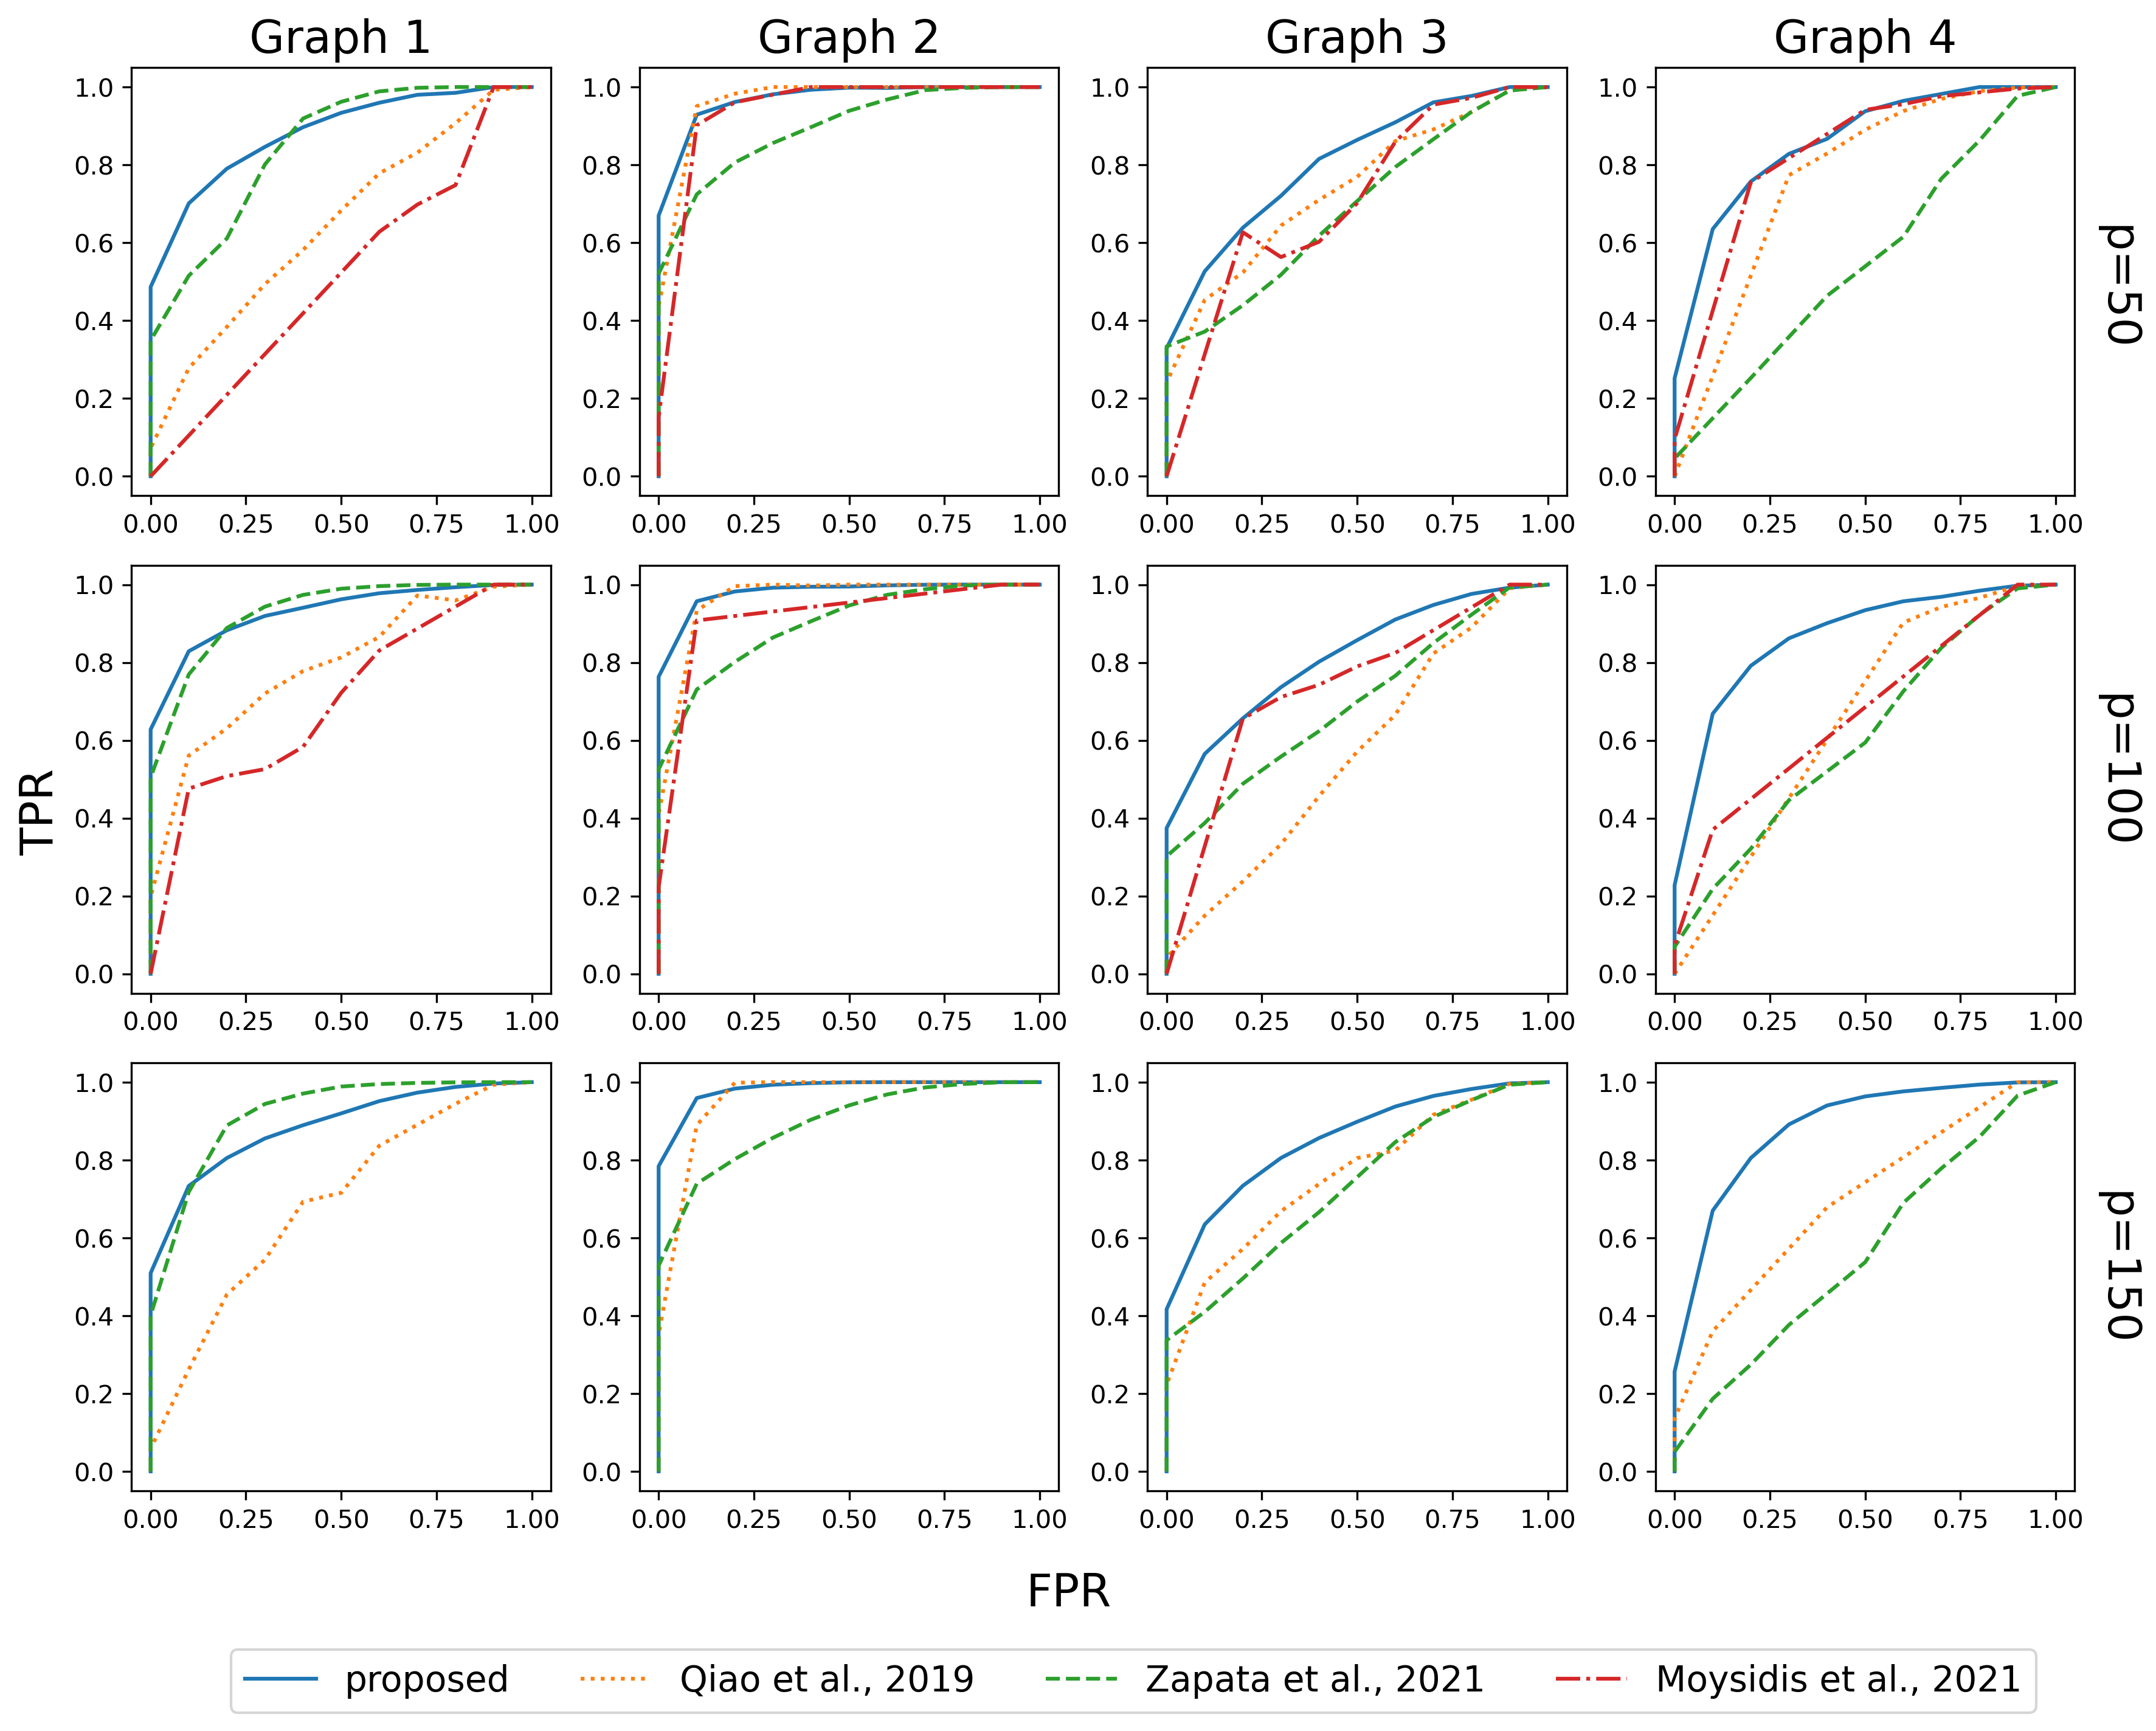

In [8]:
fig, ax = plt.subplots(3,4,figsize=(12, 9), dpi=300)
#for data20
rate_list = [[332, 342, 332], [232, 232, 242], [232, 443, 443], [232, 232, 242]]#, [232, 242, 242]]
#for data21
#rate_list = [[322, 322, 443], [232, 232, 242], [322, 443, 322], [232, 232, 242]]#, [432, 242, 322]]
name_list = ['tridiag1', 'tridiag2', 'tridiag3', 'power']#, 'random']
p_list = [50, 100, 150]
fig.supxlabel('FPR',fontsize=18)
fig.supylabel('TPR',fontsize=18)
for i, name in enumerate(name_list):
    for j, p in enumerate(p_list):
        if j == 0:
            ax[j,i].set_title("Graph {}".format(i+1), fontsize=18)
        if i == 3:
            ax[j,i].text(1.1, 0.35, 'p={}'.format(p_list[j]),  fontsize=18, rotation=-90)
        test_model = '{}_p{}_N100'.format(name, p)
        model_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results20_batch/'
        rest_of_name = 'model3_{}_Iest_noise3_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, rate_list[i][j])

        plot_mean_auc( ax[j,i], model_path, rest_of_name, label='proposed', linestyle='solid', color=color_map(0))

        cmodel_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results_c20_batch/'
        rest_of_name = '{}_noise3_light.RunInd4.Rdata'.format(test_model)


        plot_mean_auc_joint(ax[j,i], cmodel_path, rest_of_name, label=['Qiao et al., 2019', 'Zapata et al., 2021'], linestyle=['dotted', 'dashed'], color = [color_map(1), color_map(2)])

        rest_of_name = '{}_noise3_jfggm_stage2_100.RunInd1.Rdata'.format(test_model)

        if  j <= 1:
            plot_mean_auc_jfggm(ax[j,i], cmodel_path, rest_of_name, label='Moysidis et al., 2021', linestyle='dashdot', color=color_map(3))

handles, labels = ax[0,0].get_legend_handles_labels()

fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0.95, -0.0), prop={'size': 14})


fig.tight_layout()
#fig.savefig('../../images/roc/compare_id20_average_horizontal2'+'.png', bbox_inches='tight')


### plot graph 20

file does not exist:/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results20_batch/ss_7/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy
file does not exist:/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results20_batch/ss_8/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy
file does not exist:/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results20_batch/ss_9/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy
file does not exist:/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results20_batch/ss_10/model3_power_p150_N100_Iest_noise3_thre0.001_rate242_run8_tprfpr.npy


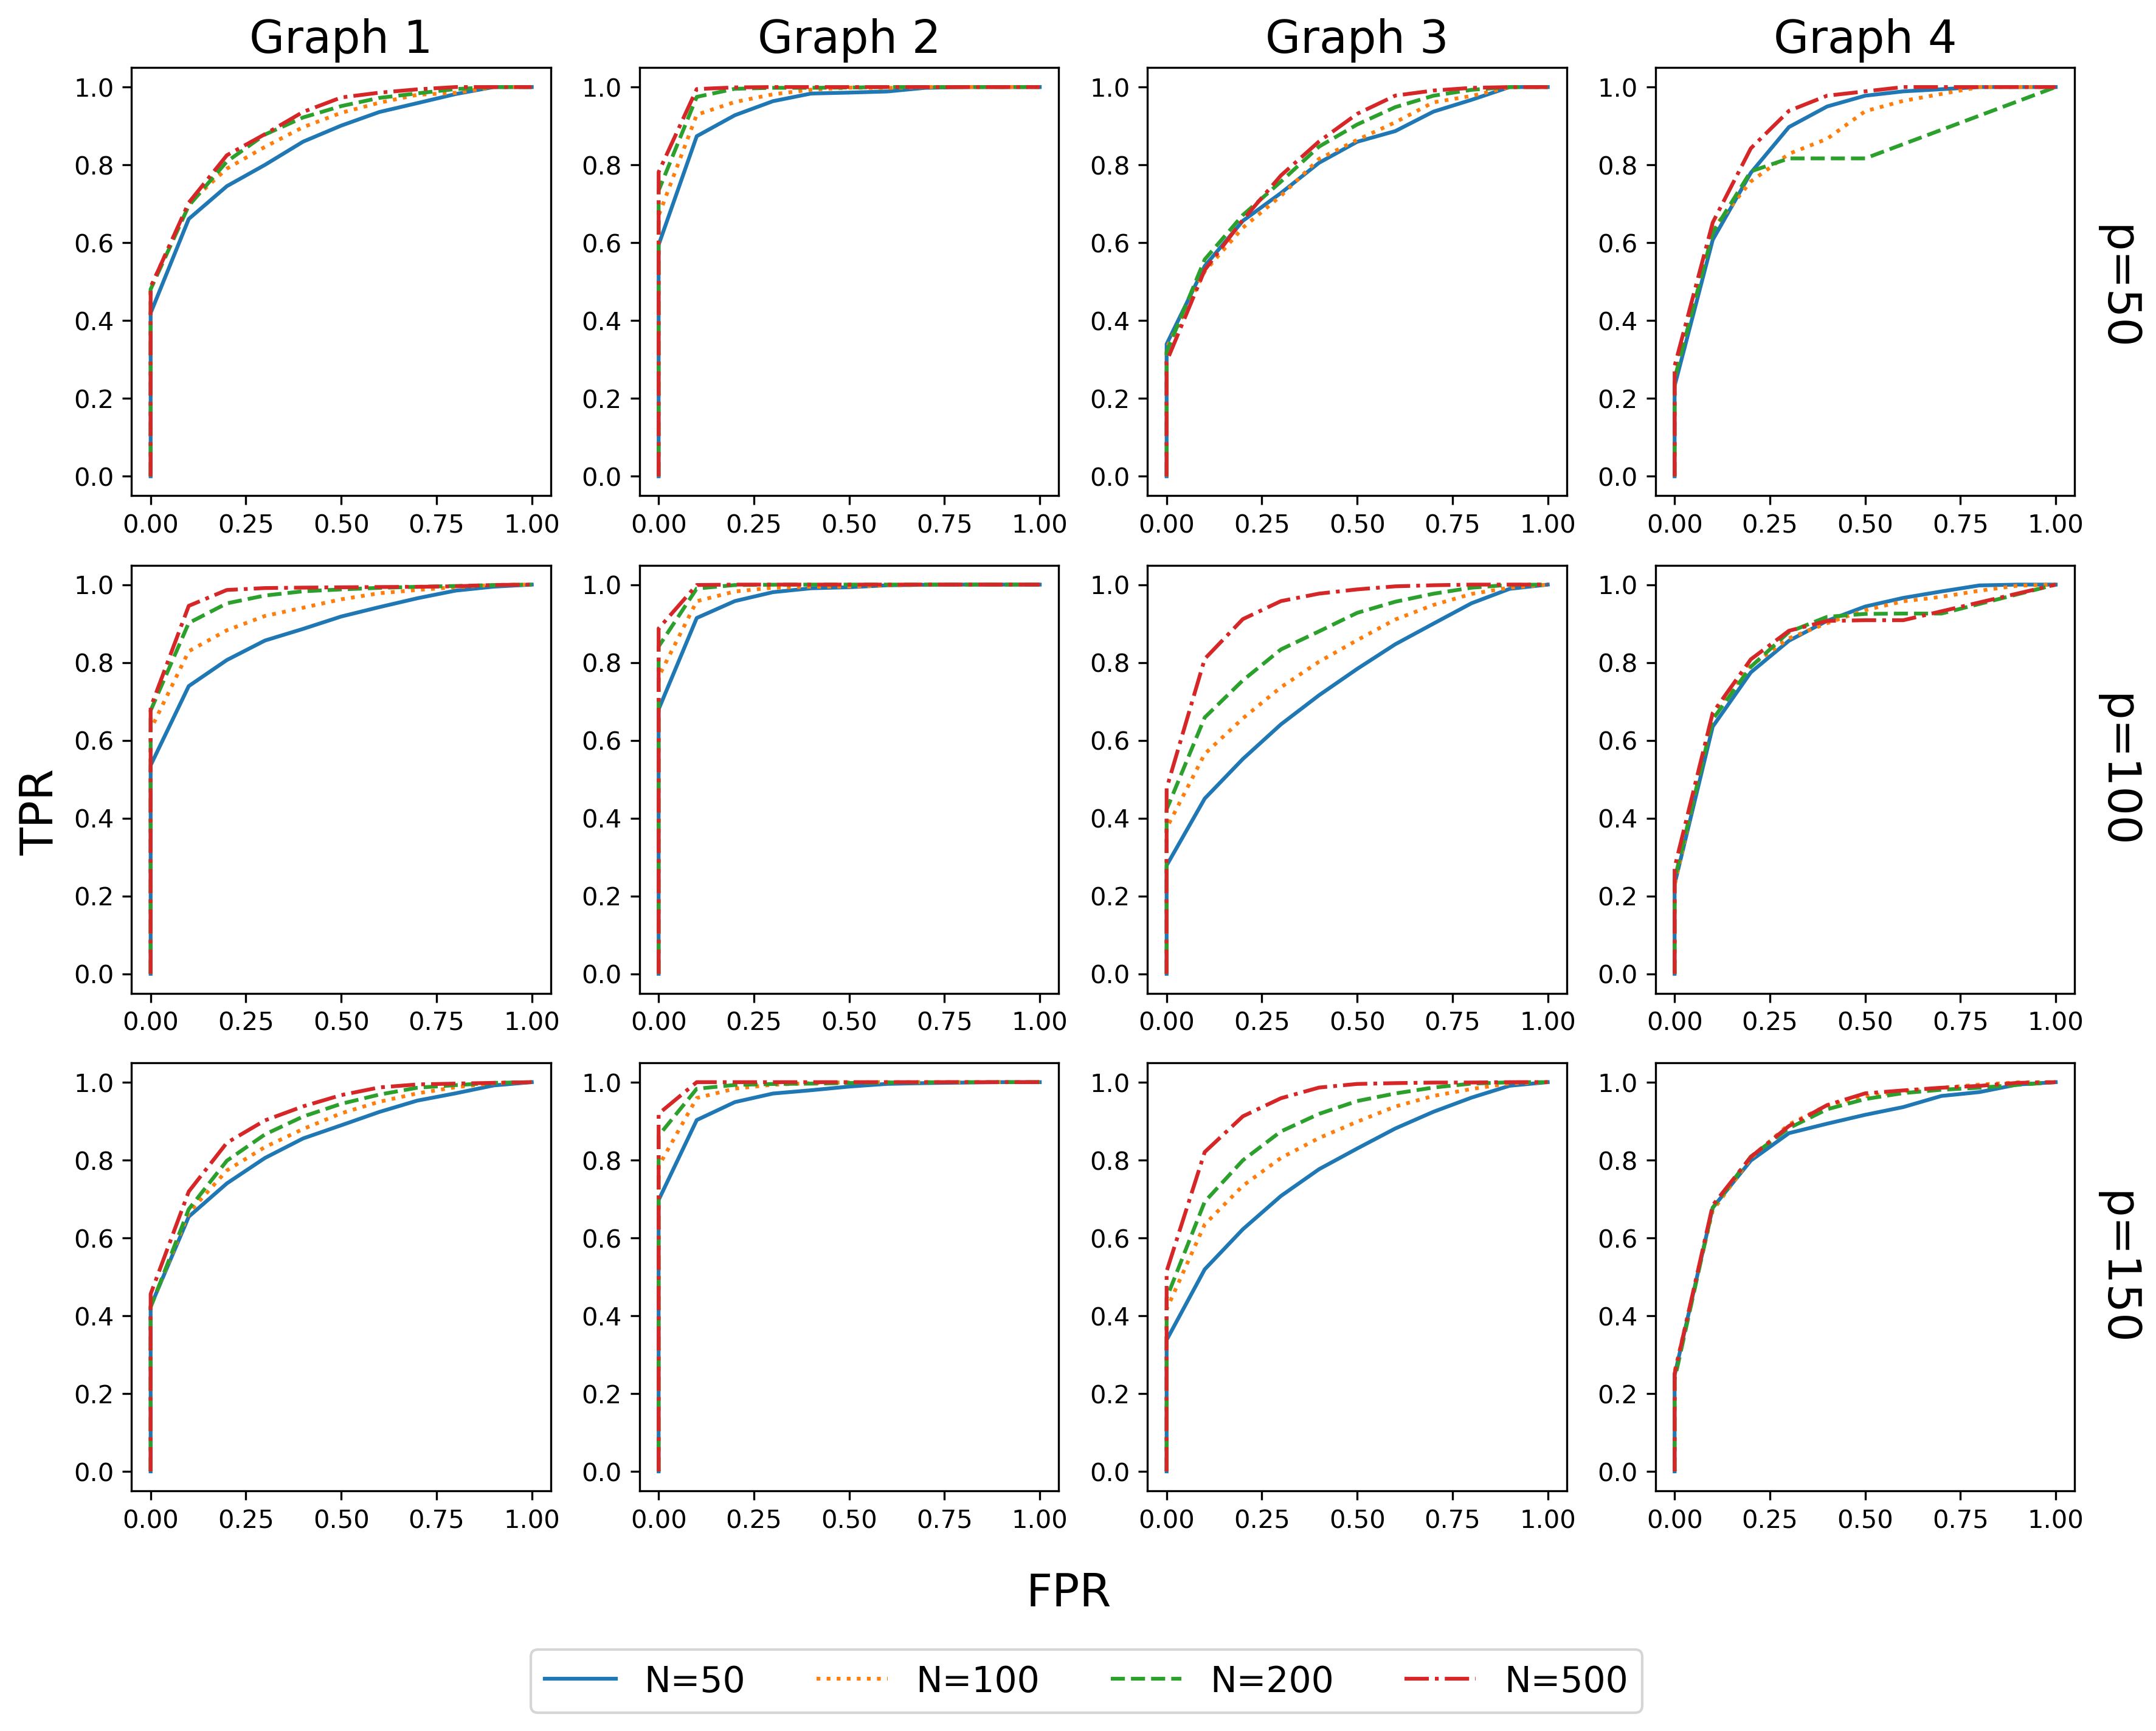

In [28]:
fig, ax = plt.subplots(3,4,figsize=(12, 9), dpi=300)
#for data20
rate_list = [[332, 342, 343], [232, 232, 242], [232, 443, 443], [232, 232, 242]]#, [232, 242, 242]]
#for data21
#rate_list = [[322, 322, 443], [232, 232, 242], [322, 443, 322], [232, 232, 242]]#, [432, 242, 322]]
name_list = ['tridiag1', 'tridiag2', 'tridiag3', 'power']#, 'random']
line_list = ['solid','dotted', 'dashed','dashdot']
p_list = [50, 100, 150]
fig.supxlabel('FPR',fontsize=18)
fig.supylabel('TPR',fontsize=18)
for i, name in enumerate(name_list):
    for j, p in enumerate(p_list):
        if j == 0:
            ax[j,i].set_title("Graph {}".format(i+1), fontsize=18)
        if i == 3:
            ax[j,i].text(1.1, 0.35, 'p={}'.format(p_list[j]),  fontsize=18, rotation=-90)
        
        for k, N in enumerate([50,100,200,500]):
            test_model = '{}_p{}_N{}'.format(name, p, N)
            
            if N == 100:
                model_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results20_batch/'
            else: 

                model_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_vision/results20_batch/'

            if test_model == 'tridiag1_p150_N50':
                rest_of_name = 'model3_{}_Iest_noise3_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, 332)
            else:
                rest_of_name = 'model3_{}_Iest_noise3_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, rate_list[i][j])

            plot_mean_auc( ax[j,i], model_path, rest_of_name, label='N={}'.format(N), linestyle=line_list[k], color=color_map(k))


handles, labels = ax[0,0].get_legend_handles_labels()

fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0.77, -0.0), prop={'size': 14})


fig.tight_layout()
fig.savefig('../../images/roc/compare_id20_average_samplesize_horizontal'+'.pdf', bbox_inches='tight')


### plot graph 21

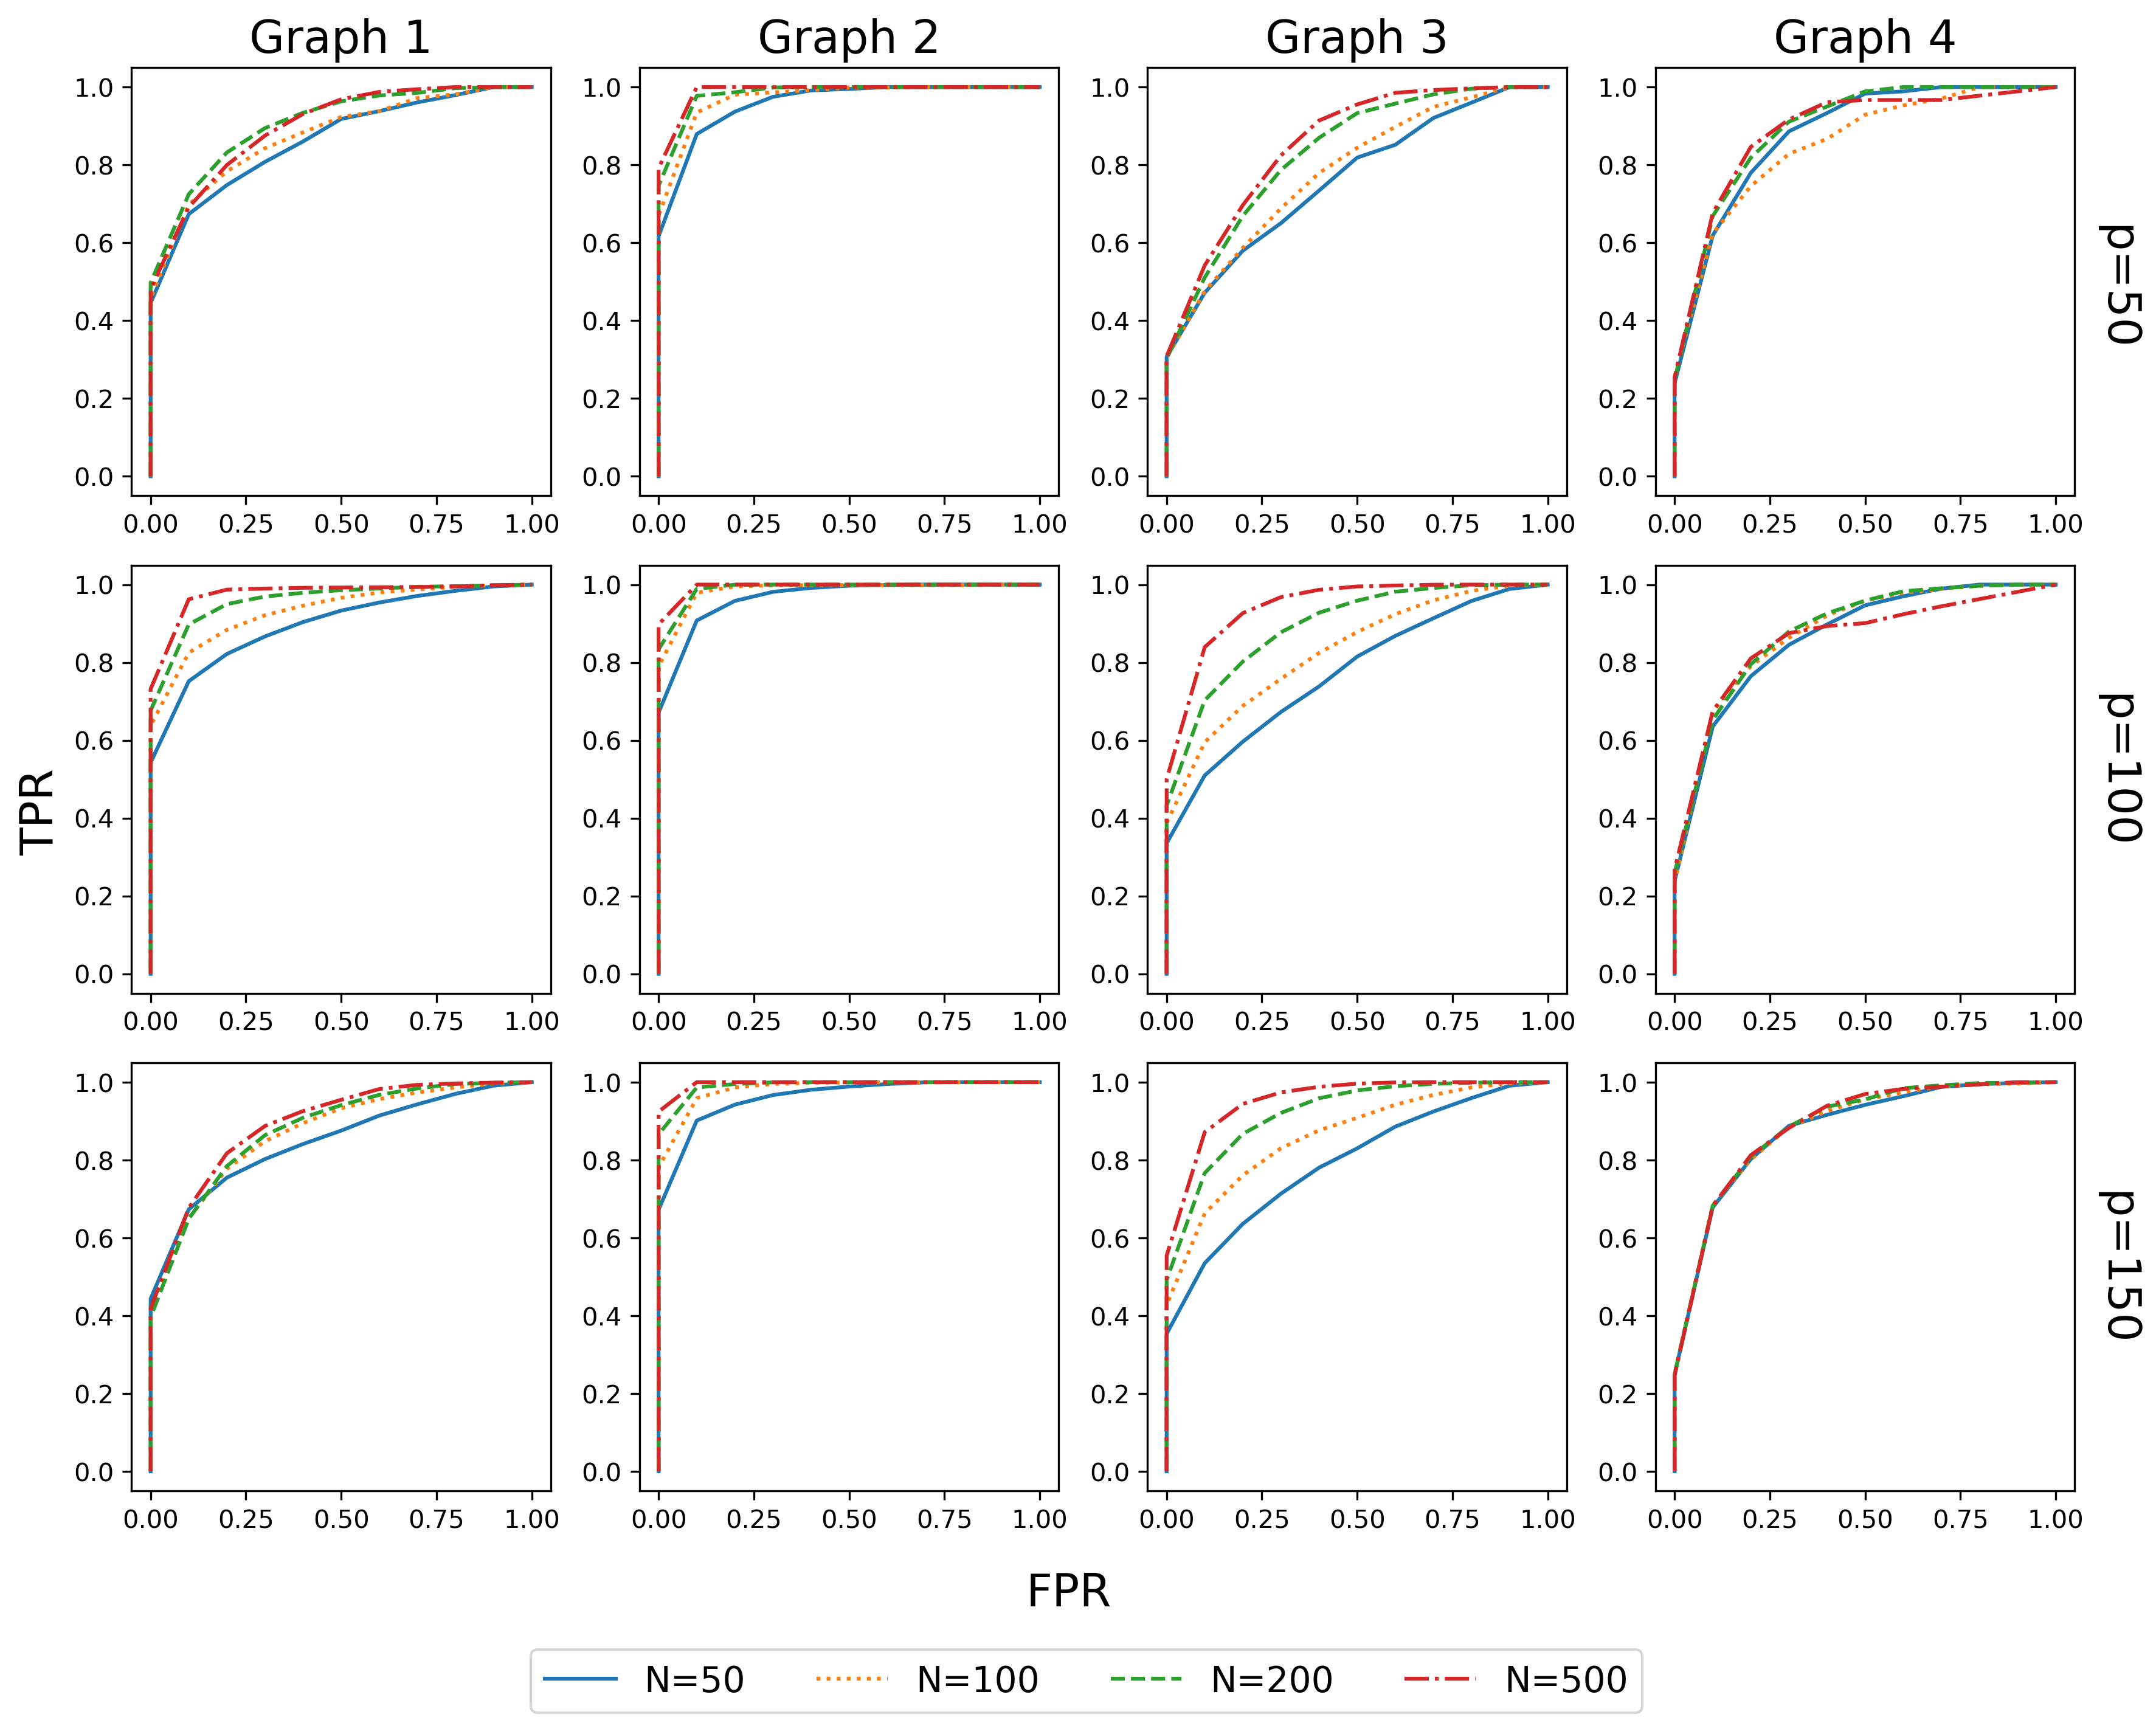

In [29]:
fig, ax = plt.subplots(3,4,figsize=(12, 9), dpi=300)
#for data20
rate_list = [[332, 342, 343], [232, 232, 242], [232, 443, 443], [232, 232, 232]]#, [232, 242, 242]]
#for data21
#rate_list = [[322, 322, 443], [232, 232, 242], [322, 443, 322], [232, 232, 242]]#, [432, 242, 322]]
name_list = ['tridiag1', 'tridiag2', 'tridiag3', 'power']#, 'random']
line_list = ['solid','dotted', 'dashed','dashdot']
p_list = [50, 100, 150]
fig.supxlabel('FPR',fontsize=18)
fig.supylabel('TPR',fontsize=18)
for i, name in enumerate(name_list):
    for j, p in enumerate(p_list):
        if j == 0:
            ax[j,i].set_title("Graph {}".format(i+1), fontsize=18)
        if i == 3:
            ax[j,i].text(1.1, 0.35, 'p={}'.format(p_list[j]),  fontsize=18, rotation=-90)
        
        for k, N in enumerate([50,100,200,500]):
            test_model = '{}_p{}_N{}'.format(name, p, N)
            
            if N == 100:
                model_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results21_batch/'
            else: 
                if name == 'power':
                    model_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/result_jul/results21_batch/'
                else:
                    model_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_vision/results21_batch/'

            if test_model == 'tridiag1_p150_N50':
                rest_of_name = 'model3_{}_Iest_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, 332)
            else:
                rest_of_name = 'model3_{}_Iest_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, rate_list[i][j])

            plot_mean_auc( ax[j,i], model_path, rest_of_name, label='N={}'.format(N), linestyle=line_list[k], color=color_map(k))


handles, labels = ax[0,0].get_legend_handles_labels()

fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0.77, -0.0), prop={'size': 14})


fig.tight_layout()
fig.savefig('../../images/roc/compare_id21_average_samplesize_horizontal'+'.pdf', bbox_inches='tight')


In [30]:
def drop_intermediate(a,b):
    return a,b

In [31]:
def compute_avg_auc():

    
    def comparison_exist():
        qiao_fpr = np.array(obj['roc']['FPR.qiao'])
        qiao_tpr = np.array(obj['roc']['TPR.qiao'])

        sort_fpr = np.argsort(qiao_fpr)

        qiao = np.zeros((qiao_tpr.shape[0], 2))
        qiao[:,0] = qiao_fpr[sort_fpr]
        qiao[:,1] = qiao_tpr[sort_fpr]
        m = remove_duplicate(qiao[:,0], qiao[:,1])

        #if m.shape[0]<=4:
        ##    plt.step(m[:,0], m[:,1], '-o', where='post', label='Qiao et al., 2019')
        #else:
        q_fpr, q_tpr= drop_intermediate(m[:,0],m[:,1])
        X_Y_Spline = make_interp_spline(q_fpr, q_tpr, k=1)
        X_ = np.linspace(np.min(q_fpr), np.max(q_fpr), 20)
        Y_ = X_Y_Spline(X_)
        plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dotted',  label='Qiao et al., 2019')
            #plt.plot(m[:,0],m[:,1], linestyle='dotted', label='Qiao et al., 2019')
        return calculate_auc(m), calculate_auc15(m)

    def zapata_exist():
        zapata_fpr = np.array(obj['roc']['FPR.zapata'])
        zapata_tpr = np.array(obj['roc']['TPR.zapata'])
        sort_fpr = np.argsort(zapata_fpr)

        zapata = np.zeros((zapata_tpr.shape[0],2))
        zapata[:,0] = zapata_fpr[sort_fpr]
        zapata[:,1] = zapata_tpr[sort_fpr]
        m = remove_duplicate(zapata[:,0], zapata[:,1])

        #if m.shape[0] <= 4:
        #    plt.step(m[:,0], m[:,1], '-o', where='post', label='Zapata et al., 2021')
        #else:
        z_fpr, z_tpr= drop_intermediate(m[:,0],m[:,1])
        X_Y_Spline = make_interp_spline(z_fpr, z_tpr, k=1)
        X_ = np.linspace(np.min(z_fpr), np.max(z_tpr), 20)
        Y_ = X_Y_Spline(X_)
        plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dashed', label='Zapata et al., 2021')
            #plt.plot(m[:,0],m[:,1], linestyle='dashed', label='Zapata et al., 2021')
        return calculate_auc(m), calculate_auc15(m)
    def jfggm_exist():
        jfggm_fpr = np.array(obj['roc']['FPR.jfggm'])
        jfggm_tpr = np.array(obj['roc']['TPR.jfggm'])

        test_num = len(obj['roc']['TPR.jfggm']) // 50
        max_area = 0
        max_i = -1

        #select b that has the largest ROC
        for i in range(test_num):
            tpr_jfggm = obj['roc']['TPR.jfggm'][i*50:(i+1)*50]
            fpr_jfggm = obj['roc']['FPR.jfggm'][i*50:(i+1)*50]
            m = remove_duplicate(fpr_jfggm , tpr_jfggm)
            area = calculate_auc(m)
            #print("index: " , i, " area: ", area)
            if area >= max_area:
                max_area = area
                max_i = i

        #print(max_i)
        tpr_jfggm = obj['roc']['TPR.jfggm'][max_i*50:(max_i+1)*50]
        fpr_jfggm = obj['roc']['FPR.jfggm'][max_i*50:(max_i+1)*50]
        
        sort_fpr = np.argsort(jfggm_fpr)

        jfggm = np.zeros((jfggm_tpr.shape[0],2))
        jfggm[:,0] = jfggm_fpr[sort_fpr]
        jfggm[:,1] = jfggm_tpr[sort_fpr]
        #print(jfggm.shape)
        m = remove_duplicate(jfggm[:,0], jfggm[:,1])

        return calculate_auc(m), calculate_auc15(m)

    auc_q_list = []
    auc15_q_list = []
    auc_z_list = []
    auc15_z_list = []
    auc_m_list = []
    auc15_m_list = []
    for i in range(10):
        comparison_filepath = comparison_path+"ss_{}/".format(i+1)+filename+noise_model+'_light.RunInd4.Rdata'
        
        if(exists(comparison_filepath)):
            obj = pyreadr.read_r(comparison_filepath)
            auc_q, auc15_q = comparison_exist()
            auc_q_list.append(auc_q)
            auc15_q_list.append(auc15_q)

            auc_z, auc15_z = zapata_exist()
            auc_z_list.append(auc_z)
            auc15_z_list.append(auc15_z)
            #print('load file from directory: '+ './results_c_vision/')
        else:
            print("file: "+ comparison_filepath+" not exist")

        
        jfggm_filepath = comparison_path+"ss_{}/".format(i+1)+filename+noise_model+'_jfggm_stage2_100.RunInd1.Rdata'
        if(exists(jfggm_filepath)):
            obj = pyreadr.read_r(jfggm_filepath)
            auc_m, auc15_m = jfggm_exist()
            auc_m_list.append(auc_m)
            auc15_m_list.append(auc15_m)            
        else:
            print("file: "+ jfggm_filepath + " not exist")
            pass

    auc_q_list = np.array(remove_outlier(auc_q_list,1)[0])
    auc15_q_list =  np.array(remove_outlier(auc15_q_list,1)[0])
    auc_z_list = np.array(remove_outlier(auc_z_list)[0])
    auc15_z_list = np.array(remove_outlier(auc15_z_list)[0])
    auc_m_list = np.array(remove_outlier(auc_m_list)[0])
    auc15_m_list = np.array(remove_outlier(auc15_m_list)[0])
    np.set_printoptions(precision=2)
    print(len(auc_q_list), len(auc15_q_list))
    print('Average AUC of qiao et al., 2019 : %.2f(%.2f)'%(np.mean(auc_q_list), np.std(auc_q_list)))
    print('Average AUC15 of qiao et al., 2019:  %.2f(%.2f)'%(np.mean(auc15_q_list), np.std(auc15_q_list)))
    print(len(auc_z_list), len(auc15_z_list))
    print('Average AUC of zapata et al., 2021:  %.2f(%.2f)'%(np.mean(auc_z_list), np.std(auc_z_list)))
    print('Average AUC15 of zapata et al., 2021:  %.2f(%.2f)'%(np.mean(auc15_z_list), np.std(auc15_z_list)))
    print(len(auc_m_list), len(auc15_m_list))
    print(auc15_m_list)
    print('Average AUC of Moysidis et al., 2021:  %.2f(%.2f)'%(np.mean(auc_m_list), np.std(auc_m_list)))
    print('Average AUC15 of Moysidis et al., 2021:  %.2f(%.2f)'%(np.mean(auc15_m_list), np.std(auc15_m_list)))

In [32]:
def call_this():


    
    #plt.plot(m[:,0],m[:,1], linestyle='solid', label="proposed model")
    comparison_filepath = comparison_path+filename+noise_model+'_light.RunInd4.Rdata'

    def comparison_exist():
        qiao_fpr = np.array(obj['roc']['FPR.qiao'])
        qiao_tpr = np.array(obj['roc']['TPR.qiao'])

        sort_fpr = np.argsort(qiao_fpr)

        qiao = np.zeros((qiao_tpr.shape[0], 2))
        qiao[:,0] = qiao_fpr[sort_fpr]
        qiao[:,1] = qiao_tpr[sort_fpr]
        m = remove_duplicate(qiao[:,0], qiao[:,1])

        #if m.shape[0]<=4:
        ##    plt.step(m[:,0], m[:,1], '-o', where='post', label='Qiao et al., 2019')
        #else:
        q_fpr, q_tpr= drop_intermediate(m[:,0],m[:,1])
        X_Y_Spline = make_interp_spline(q_fpr, q_tpr, k=1)
        X_ = np.linspace(np.min(q_fpr), np.max(q_fpr), 20)
        Y_ = X_Y_Spline(X_)
        plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dotted',  label='Qiao et al., 2019')
            #plt.plot(m[:,0],m[:,1], linestyle='dotted', label='Qiao et al., 2019')
        return calculate_auc(m)
    auc_q = 0
    if(exists(comparison_filepath)):
        obj = pyreadr.read_r(comparison_filepath)
        auc_q = comparison_exist()
        
        #print('load file from directory: '+ './results_c_vision/')
    else:
        print("file: "+ comparison_filepath+" not exist")


    def zapata_exist():
        zapata_fpr = np.array(obj['roc']['FPR.zapata'])
        zapata_tpr = np.array(obj['roc']['TPR.zapata'])
        sort_fpr = np.argsort(zapata_fpr)

        zapata = np.zeros((zapata_tpr.shape[0],2))
        zapata[:,0] = zapata_fpr[sort_fpr]
        zapata[:,1] = zapata_tpr[sort_fpr]
        m = remove_duplicate(zapata[:,0], zapata[:,1])

        #if m.shape[0] <= 4:
        #    plt.step(m[:,0], m[:,1], '-o', where='post', label='Zapata et al., 2021')
        #else:
        z_fpr, z_tpr= drop_intermediate(m[:,0],m[:,1])
        X_Y_Spline = make_interp_spline(z_fpr, z_tpr, k=1)
        X_ = np.linspace(np.min(z_fpr), np.max(z_tpr), 20)
        Y_ = X_Y_Spline(X_)
        plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dashed', label='Zapata et al., 2021')
            #plt.plot(m[:,0],m[:,1], linestyle='dashed', label='Zapata et al., 2021')
        return calculate_auc(m)
    auc_z = 0

    if(exists(comparison_filepath)):
        auc_z = zapata_exist()
    #    pass



    def jfggm_exist():
        jfggm_fpr = np.array(obj['roc']['FPR.jfggm'])
        jfggm_tpr = np.array(obj['roc']['TPR.jfggm'])

        test_num = len(obj['roc']['TPR.jfggm']) // 50
        max_area = 0
        max_i = -1

        #select b that has the largest ROC
        for i in range(test_num):
            tpr_jfggm = obj['roc']['TPR.jfggm'][i*50:(i+1)*50]
            fpr_jfggm = obj['roc']['FPR.jfggm'][i*50:(i+1)*50]
            m = remove_duplicate(fpr_jfggm , tpr_jfggm)
            area = calculate_auc(m)
            #print("index: " , i, " area: ", area)
            if area >= max_area:
                max_area = area
                max_i = i

        #print(max_i)
        tpr_jfggm = obj['roc']['TPR.jfggm'][max_i*50:(max_i+1)*50]
        fpr_jfggm = obj['roc']['FPR.jfggm'][max_i*50:(max_i+1)*50]
        
        sort_fpr = np.argsort(jfggm_fpr)

        jfggm = np.zeros((jfggm_tpr.shape[0],2))
        jfggm[:,0] = jfggm_fpr[sort_fpr]
        jfggm[:,1] = jfggm_tpr[sort_fpr]
        #print(jfggm.shape)
        m = remove_duplicate(jfggm[:,0], jfggm[:,1])
        print(m.shape)
        #if m.shape[0] <= 4:
        #    plt.step(m[:,0], m[:,1], '-o', where='post', label="Moysidis et al., 2021")
        #else:

        m_fpr, m_tpr= drop_intermediate(m[:,0],m[:,1])
        X_Y_Spline = make_interp_spline(m_fpr, m_tpr, k=1)
        X_ = np.linspace(np.min(m_fpr), np.max(m_fpr), 20)
        Y_ = X_Y_Spline(X_)
        #plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), '-o')
        plt.plot(np.hstack((0.,X_)), np.hstack((0.,Y_)), linestyle='dashdot', label="Moysidis et al., 2021")
        #plt.plot(m_fpr, m_tpr, linestyle='dashdot', label="Moysidis et al., 2021")

    
    jfggm_filepath = comparison_path+filename+noise_model+'_jfggm_stage2_100.RunInd1.Rdata'
    if(exists(jfggm_filepath)):
        obj = pyreadr.read_r(jfggm_filepath)
        jfggm_exist()
    else:

        print("file: "+ jfggm_filepath + " not exist")
        pass

    plt.legend()
    plt.show()

In [33]:
def select_best_gradeint(rate_batch):

    for rate in rate_batch:
        auc_r = []
        auc15_r = []
        for i in range(10):
            p_file = model_path+"ss_{}/".format(i)+"model3_"+filename+"_Iest" + noise_model +"_thre0.001_rate{}_run8_tprfpr.npy".format(rate)
            if(exists(p_file)):

                arr = np.load(p_file)
                sort_fpr = np.argsort(arr[:,1])

                flng = np.zeros(arr.shape)
                flng[:,0] = arr[sort_fpr,0]
                flng[:,1] = arr[sort_fpr,1]

                m = remove_duplicate(flng[:,1], flng[:,0])
                #print(calculate_auc(m))
                auc_r.append(calculate_auc(m))
                auc15_r.append(calculate_auc15(m))
        if len(auc_r) > 0 and len(auc15_r)>0:
            auc_r = np.array(remove_outlier(auc_r)[0])
            auc15_r = np.array(remove_outlier(auc15_r)[0])
            print(len(auc_r), len(auc15_r))
            print("rate: ",rate, "AUC: %.2f(%.2f)"%(np.mean(auc_r), np.std(auc_r)), "AUC15: %.2f(%.2f)"%(np.mean(auc15_r), np.std(auc15_r)))

        




In [42]:
def print_result(N,file_batch):
    auc_l = []
    auc15_l = []
    for file in file_batch:
        auc_r = []
        auc15_r = []
        for i in range(10):
            p_file = file[0]+"ss_{}/".format(i)+file[1]
            if(exists(p_file)):

                arr = np.load(p_file)
                sort_fpr = np.argsort(arr[:,1])

                flng = np.zeros(arr.shape)
                flng[:,0] = arr[sort_fpr,0]
                flng[:,1] = arr[sort_fpr,1]

                m = remove_duplicate(flng[:,1], flng[:,0])
                #print(calculate_auc(m))
                auc_r.append(calculate_auc(m))
                auc15_r.append(calculate_auc15(m))
        if len(auc_r) > 0 and len(auc15_r)>0:
            auc_r = np.array(remove_outlier(auc_r)[0])
            auc15_r = np.array(remove_outlier(auc15_r)[0])
            auc_l.append(auc_r)
            auc15_l.append(auc15_r)
    out_str = '$N={}$& '.format(N)
    for auc in auc_l:
        out_str += " &$%.2f(%.2f)$ "%(np.mean(auc), np.std(auc))
    for auc15 in auc15_l:
        out_str += " &$%.2f(%.2f)$ "%(np.mean(auc15), np.std(auc15))
    out_str += "\\\\"
    print(out_str)  

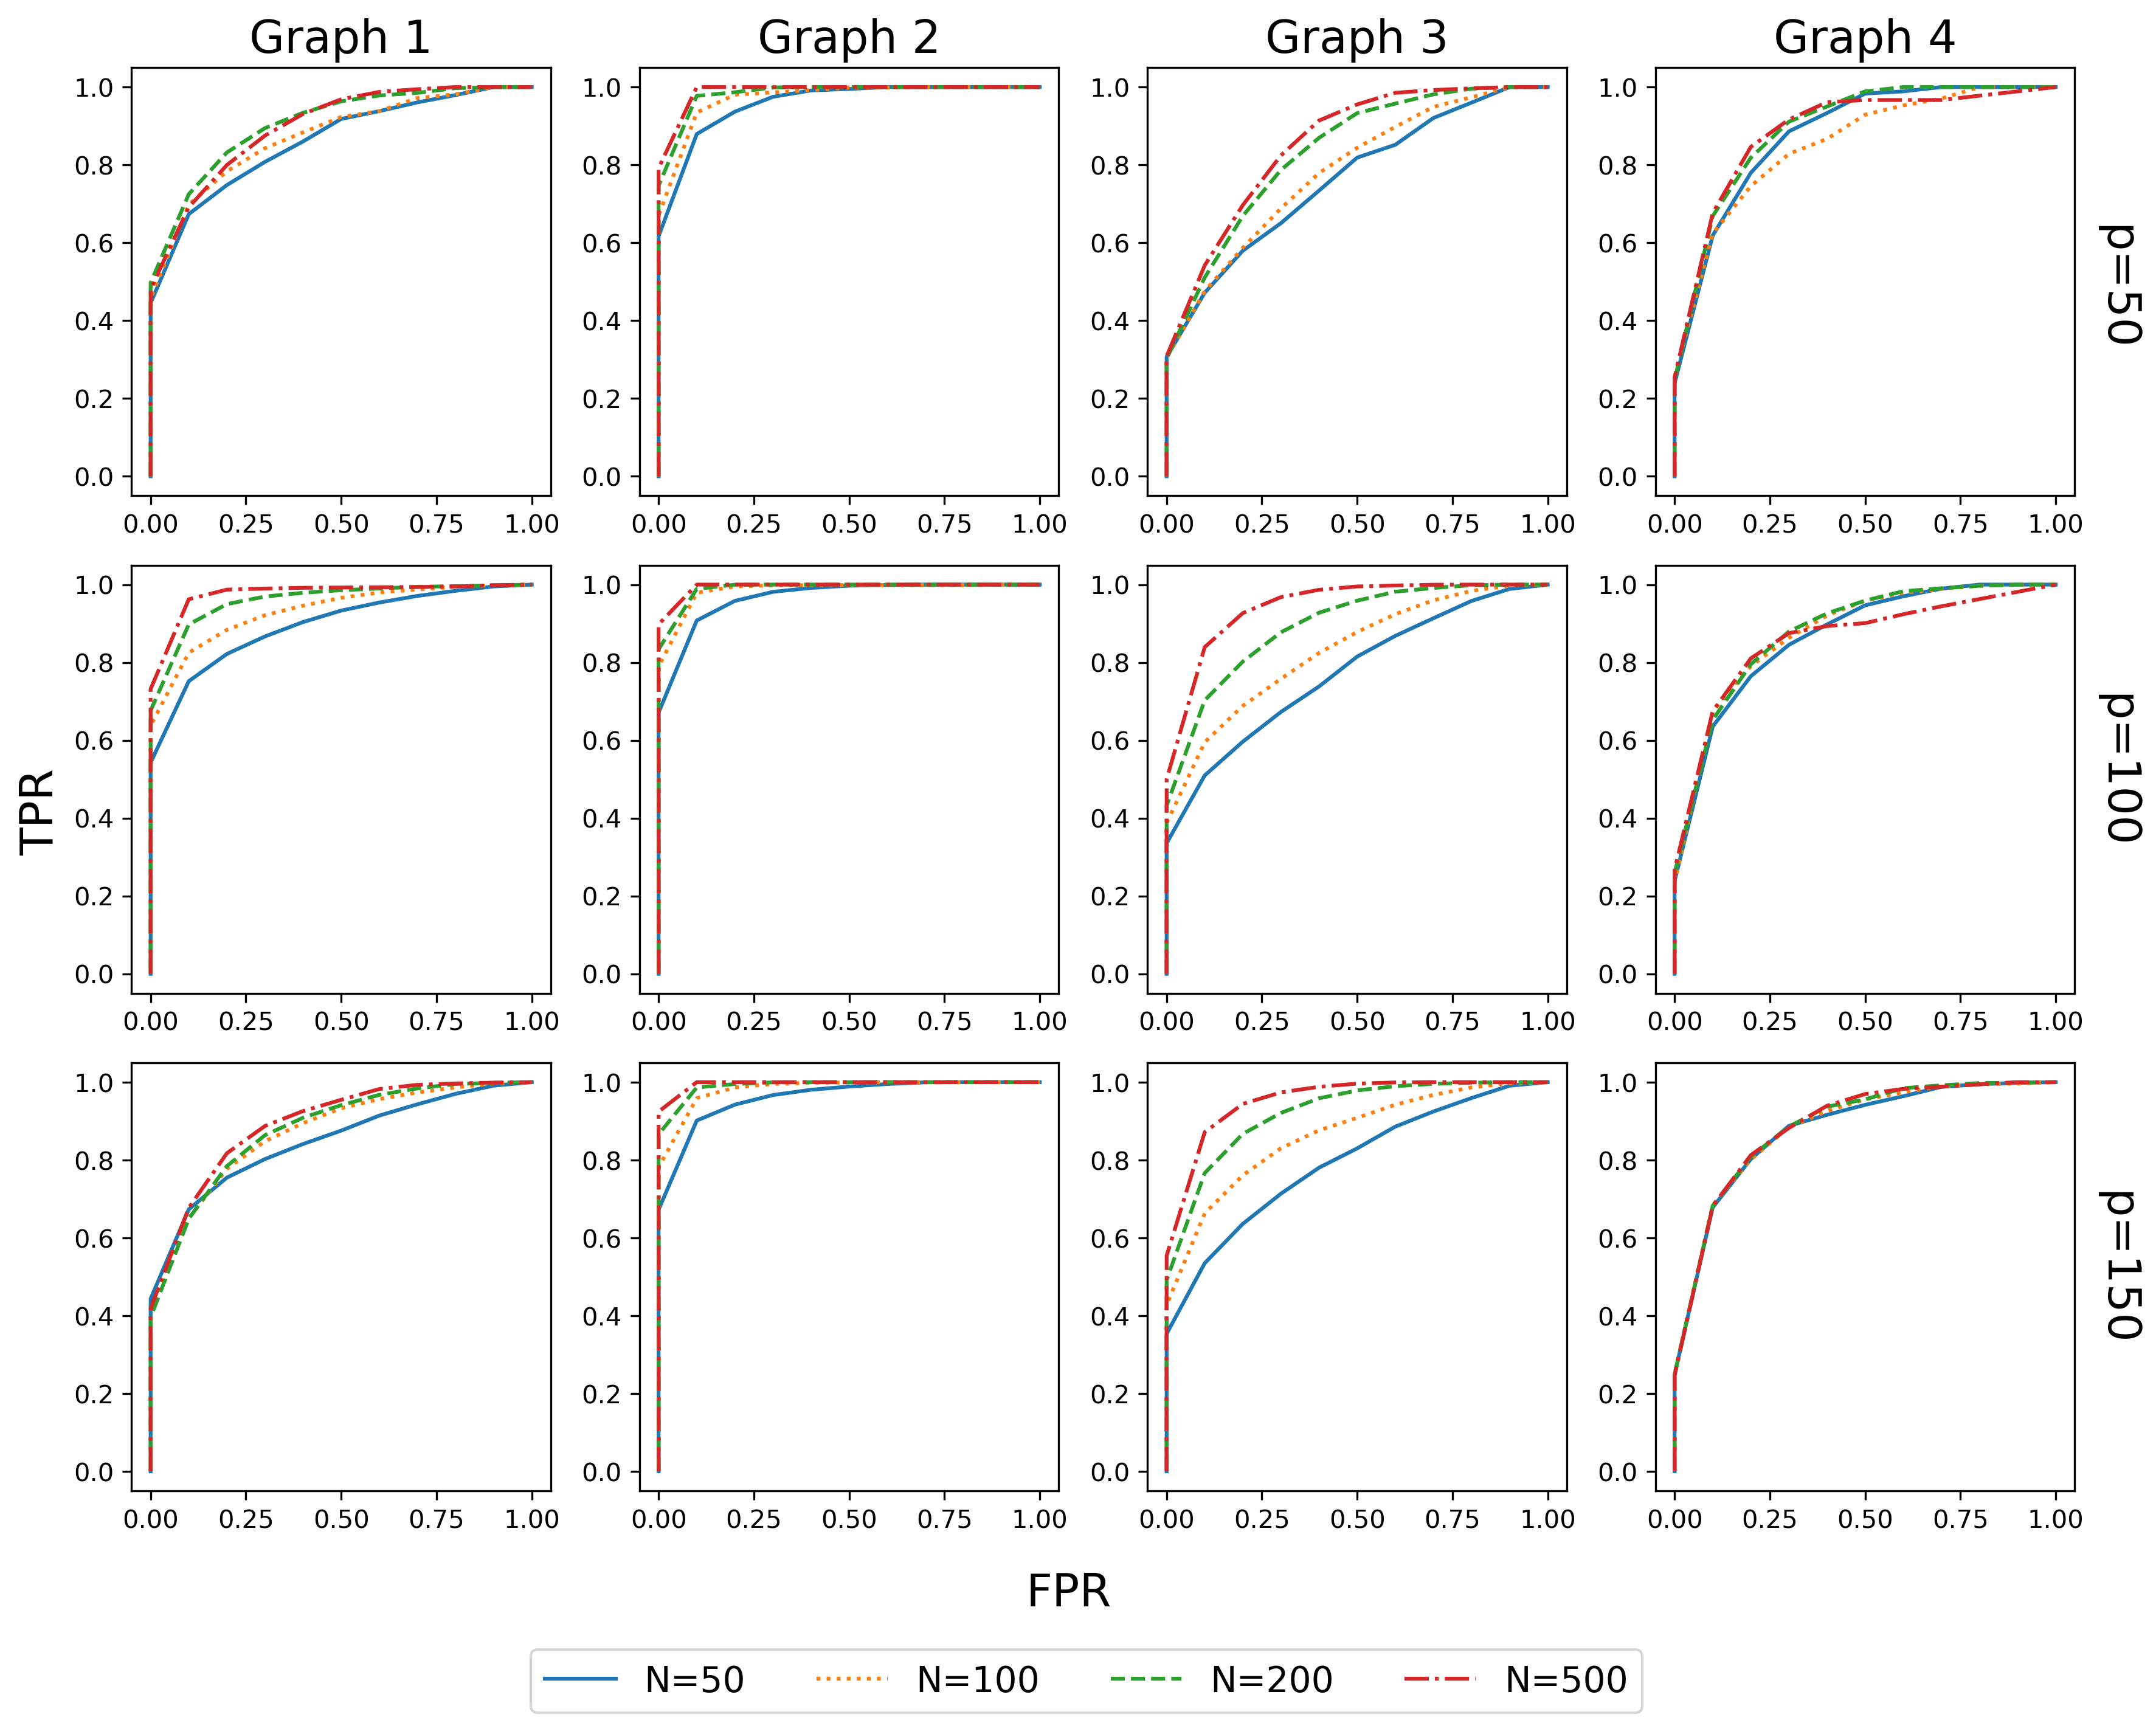

In [35]:
fig, ax = plt.subplots(3,4,figsize=(12, 9), dpi=300)
#for data20
rate_list = [[332, 342, 343], [232, 232, 242], [232, 443, 443], [232, 232, 232]]#, [232, 242, 242]]
#232,322,332,342,343,432,443
#for data21
#rate_list = [[322, 322, 443], [232, 232, 242], [322, 443, 322], [232, 232, 242]]#, [432, 242, 322]]
name_list = ['tridiag1', 'tridiag2', 'tridiag3', 'power']#, 'random']
line_list = ['solid','dotted', 'dashed','dashdot']
p_list = [50, 100, 150]
fig.supxlabel('FPR',fontsize=18)
fig.supylabel('TPR',fontsize=18)
for i, name in enumerate(name_list):
    for j, p in enumerate(p_list):
        if j == 0:
            ax[j,i].set_title("Graph {}".format(i+1), fontsize=18)
        if i == 3:
            ax[j,i].text(1.1, 0.35, 'p={}'.format(p_list[j]),  fontsize=18, rotation=-90)
        
        for k, N in enumerate([50,100,200,500]):
            test_model = '{}_p{}_N{}'.format(name, p, N)
            
            if N == 100:
                model_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results21_batch/'
            else: 
                if i == 3:
                    model_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/result_jul/results21_batch/'
                else: 
                    model_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_vision/results21_batch/'
            if test_model == 'tridiag1_p150_N50':
                rest_of_name = 'model3_{}_Iest_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, 332)
            else:
                rest_of_name = 'model3_{}_Iest_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, rate_list[i][j])

            plot_mean_auc( ax[j,i], model_path, rest_of_name, label='N={}'.format(N), linestyle=line_list[k], color=color_map(k))


handles, labels = ax[0,0].get_legend_handles_labels()

fig.legend(handles, labels, ncol=4, bbox_to_anchor=(0.77, -0.0), prop={'size': 14})


fig.tight_layout()
fig.savefig('../../images/roc/compare_id21_average_samplesize_horizontal'+'.pdf', bbox_inches='tight')


In [44]:

#for data20
#rate_list = [[332, 342, 342], [232, 232, 242], [232, 443, 443], [232, 232, 242]]#, [232, 242, 242]]
rate_list = rate_list = [[332, 342, 343], [232, 232, 242], [232, 443, 443], [232, 232, 232]]#, [232, 242, 242]]

name_list = ['tridiag1', 'tridiag2', 'tridiag3', 'power']#, 'random']
line_list = ['solid','dotted', 'dashed','dashdot']
p_list = [50, 100, 150]

for i, name in enumerate(name_list):
    for k, N in enumerate([50,100,200,500]):
        name_list = []
        for j, pp in enumerate(p_list):
        
        
            test_model = '{}_p{}_N{}'.format(name, pp, N)



            if N == 100:
                model_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/results21_batch/'
            else: 
                if i == 3:
                    model_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_intel/result_jul/results21_batch/'
                else: 
                    model_path = '/Users/katherinetsai/research/multimodal_functional_ggm/result_vision/results21_batch/'
            if test_model == 'tridiag1_p150_N50':
                rest_of_name = 'model3_{}_Iest_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, 332)
            else:
                rest_of_name = 'model3_{}_Iest_thre0.001_rate{}_run8_tprfpr.npy'.format(test_model, rate_list[i][j])


            name_list.append([model_path, rest_of_name])
        #print(name_list)
        #print("model:", name, "N:", N)
        print_result( N, name_list)
        #print('-----------------------')



$N=50$&  &$0.84(0.02)$  &$0.88(0.02)$  &$0.82(0.03)$  &$0.57(0.03)$  &$0.66(0.04)$  &$0.57(0.03)$ \\
$N=100$&  &$0.85(0.01)$  &$0.92(0.01)$  &$0.84(0.01)$  &$0.58(0.02)$  &$0.74(0.02)$  &$0.48(0.02)$ \\
$N=200$&  &$0.89(0.01)$  &$0.95(0.01)$  &$0.86(0.01)$  &$0.60(0.02)$  &$0.78(0.04)$  &$0.51(0.03)$ \\
$N=500$&  &$0.88(0.01)$  &$0.97(0.01)$  &$0.87(0.01)$  &$0.59(0.01)$  &$0.83(0.03)$  &$0.52(0.03)$ \\
$N=50$&  &$0.95(0.01)$  &$0.96(0.01)$  &$0.95(0.01)$  &$0.76(0.03)$  &$0.80(0.02)$  &$0.79(0.02)$ \\
$N=100$&  &$0.97(0.01)$  &$0.98(0.01)$  &$0.98(0.00)$  &$0.82(0.03)$  &$0.90(0.03)$  &$0.88(0.01)$ \\
$N=200$&  &$0.98(0.00)$  &$0.99(0.00)$  &$0.99(0.00)$  &$0.88(0.01)$  &$0.93(0.01)$  &$0.94(0.01)$ \\
$N=500$&  &$0.98(0.00)$  &$0.99(0.00)$  &$1.00(0.00)$  &$0.90(0.01)$  &$0.96(0.00)$  &$0.97(0.00)$ \\
$N=50$&  &$0.72(0.04)$  &$0.75(0.03)$  &$0.77(0.02)$  &$0.38(0.06)$  &$0.42(0.04)$  &$0.44(0.04)$ \\
$N=100$&  &$0.77(0.05)$  &$0.80(0.03)$  &$0.85(0.02)$  &$0.38(0.04)$  &$0.48(0.04)$  